# Hindmarsh-Rose model bursting analysis

In [1]:
import brainpy as bp

The Hindmarsh-Rose model describes bursting dynamics in neurons.

"x" models the membrane potential of a bursting cell,
"y" models the main currents into and out of the cell, and
"z" models an adaptive (calcium-like) current.

In [2]:
class HR(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, y, z, t, a, b, c, d, r, s, x_r, Isyn):
        dV = y - a * V ** 3 + b * V * V - z + Isyn
        dy = c - d * V * V - y
        dz = r * (s * (V - x_r) - z)
        return dV, dy, dz

    def __init__(self, size, a=1., b=3., c=1., d=5., s=4., x_r=-1.6,
                 r=0.001, Vth=1.9, **kwargs):
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.s = s
        self.x_r = x_r
        self.r = r
        self.Vth = Vth

        # variables
        num = bp.size2len(size)
        self.V = -1.6 * bp.backend.ones(num)
        self.y = -10 * bp.backend.ones(num)
        self.z = bp.backend.zeros(num)
        self.spike = bp.backend.zeros(num, dtype=bool)
        self.input = bp.backend.zeros(num)

        self.integral = bp.odeint(f=self.derivative)

        super(HR, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, y, z = self.integral(self.V, self.y, self.z, _t,
                                self.a, self.b, self.c, self.d,
                                self.r, self.s, self.x_r, self.input)
        self.spike = (V >= self.Vth) * (self.V < self.Vth)
        self.V = V
        self.y = y
        self.z = z
        self.input[:] = 0.

### Simulation

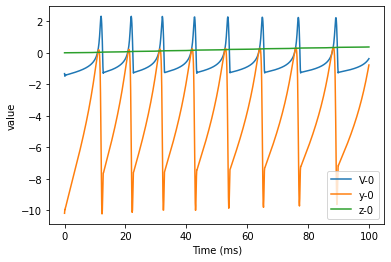

In [3]:
group = HR(1, monitors=['V', 'y', 'z'])

group.run(100., inputs=('input', 1.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='V', )
bp.visualize.line_plot(group.mon.ts, group.mon.y, legend='y', )
bp.visualize.line_plot(group.mon.ts, group.mon.z, legend='z', show=True)

### Phase plane analysis

plot nullcline ...
SymPy solve "derivative(V, y) = 0" to "y = f(V, )", success.
SymPy solve "derivative(V, y) = 0" to "y = f(V, )", success.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "derivative(V, y)" by "V", success.
SymPy solve derivative of "derivative(V, y)" by "y", success.
SymPy solve derivative of "derivative(V, y)" by "V", success.
SymPy solve derivative of "derivative(V, y)" by "y", success.
Fixed point #1 at V=0.8392867552141611, y=-2.522011287389576 is a unstable focus.
plot trajectory ...


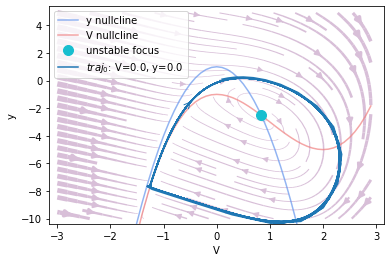

In [4]:
analyzer = bp.analysis.PhasePlane(
    group.integral,
    target_vars={'V': [-3, 3], 'y': [-10., 5.]},
    fixed_vars={'z': 0.},
    pars_update=dict(a=1., b=3., c=1., d=5., s=4., x_r=-1.6, r=0.001, Isyn=1.)
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': 0., 'y': 0.}],
                         duration=100.,
                         show=True)

## Bifurcation Diagram

plot bifurcation ...
SymPy solve "derivative(V, y, z) = 0" to "y = f(V, z)", success.
SymPy solve derivative of "derivative(V, y, z)" by "V", success.
SymPy solve derivative of "derivative(V, y, z)" by "y", success.
SymPy solve derivative of "derivative(V, y, z)" by "V", success.
SymPy solve derivative of "derivative(V, y, z)" by "y", success.
plot trajectory ...


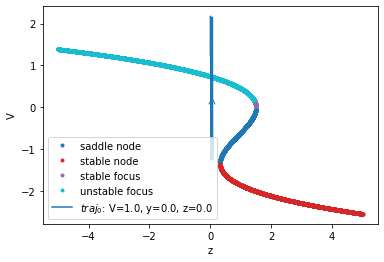

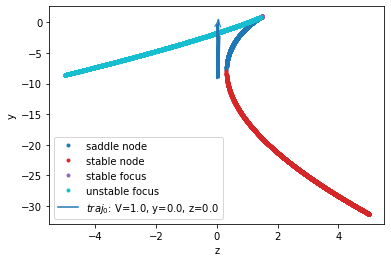

In [5]:
analyzer = bp.analysis.FastSlowBifurcation(
    group.integral,
    fast_vars={'V': [-3, 3], 'y': [-10., 5.]},
    slow_vars={'z': [-5., 5.]},
    pars_update=dict(a=1., b=3., c=1., d=5., s=4., x_r=-1.6, r=0.001, Isyn=.5),
    numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'V': 1., 'y': 0., 'z': 0.0}],
                         duration=30.,
                         show=True)

**References**:

- James L Hindmarsh and RM Rose. A model of neuronal bursting using
  three coupled first order differential equations. Proceedings
  of the Royal society of London. Series B. Biological sciences,
  221(1222):87–102, 1984.